With SMOTE:
Balanced Accuracy: 0.5165689098468902
Weighted Average AUC: 0.8061865084634707


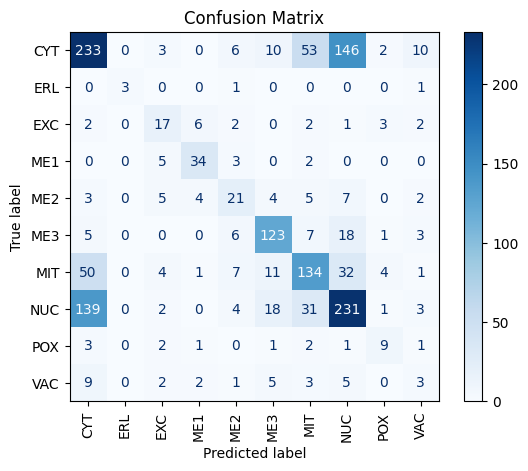

In [ ]:
# Data Science for Medicine and Biology
#
# Nezu Life Sciences
#
# Feel free to modify, redistribute and above all,
# create something with this code.
#
# Tiago Lopes, PhD
# March 2024

import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load data from the CSV file
fileName = "https://raw.githubusercontent.com/Nezu-life/Data_Science_For_Medicine_and_Biology/main/datasets/yeast_proteins.csv"
data = pd.read_csv(fileName, sep="\t")

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
data['target_encoded'] = label_encoder.fit_transform(data['target'])

# Separate features (X) and the target variable (y)
X = data.drop(['seq','target', 'target_encoded'], axis=1)
y = data['target_encoded']

# Set up cross-validation with 10 splits
cross_validator = StratifiedKFold(n_splits=5)
all_true_values = []
all_pred_probs = []

# Evaluate the model on each split
for train_index, test_index in cross_validator.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42, k_neighbors=2)
    X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

    # Create and train the model on the oversampled data
    classifier = xgb.XGBClassifier(eval_metric='mlogloss')
    classifier.fit(X_train_oversampled, y_train_oversampled)

    # Store true values and predicted probabilities
    all_true_values.extend(y_test.tolist())
    all_pred_probs.extend(classifier.predict_proba(X_test))

# Compute evaluation metrics
balanced_acc = balanced_accuracy_score(all_true_values, np.argmax(all_pred_probs, axis=1))
auc_score = roc_auc_score(all_true_values, all_pred_probs, multi_class='ovr', average='weighted')

# Compute confusion matrix
cm = confusion_matrix(all_true_values, np.argmax(all_pred_probs, axis=1))
class_labels = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Metrics output
print("With SMOTE:")
print(f"Balanced Accuracy: {balanced_acc}")
print(f"Weighted Average AUC: {auc_score}")

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()
